In [43]:
from matplotlib import pyplot as plt
import numpy as np
import math
from scipy.integrate import odeint
from scipy.integrate import solve_bvp
from PIL import Image

Battery Characteristics

In [44]:
### total charge in mAh (theoretical capacity and experimental capacity)
theoretical_capacity = 0.000675164504326091 #Ah
theoretical_capacity = 1000*theoretical_capacity #mAh 
experimental_capacity= 0.000716894394951807 #Ah
experimental_capacity = experimental_capacity*1000 #mAh

### Faraday's constant
F = 96485.33289 # C/mol

### number of physical discritized points 
N = 101  # number of points to discretize

### Total time of discharge
total_time = 41035.97 # seconds

t = np.linspace(0,total_time,N) # time array (s)

### Depth of discharge
### fraction battery has been discharge
y = t/total_time

### setting up depth into the cathode material
L = 1.0 # practice length/depth of cathode material (cm)
Lsep = 2.8e-5 * 100 # length/depth of separator (cm)
Lpos = 2e-5 *100 # length/depth of cathode (cm)
x = np.linspace(0, L, N) # position along the rod
dx = L / (N - 1)
h = L / (N - 1)

### setting up depth of diffusion into particles (r)
Diameter = 600 #Diameter of cathode particles (nm)
Diameter = Diameter/1e9 # Diameter of cathode particles (m)
Diameter = Diameter*100 #Diameter of cathode particles (cm)
R = Diameter/2
r = np.linspace(0, R, N)

### area of electrode
### CR2032 model battery casing is 20mm in diameter
re = 10 #radius of electrode(mm)
re = re/10 # radius of electrode (cm)
Ae = np.pi*re*re #cm^2

# applied current 
Iapp = 6.29282063e-05 # Amps
Iapp = Iapp*1000 #mA

# current density 
iapp = Iapp/Ae

av = 9.63e5 #1/m
av = av/100 #1/cm

Defining function to calculate i_n as a function of depth into the cathode (x) and time (t) calclated at constant concentration
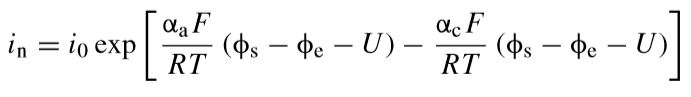
Disregarding overpotential (U)

Text(0,0.5,'$i_1$/$i_{app}$')

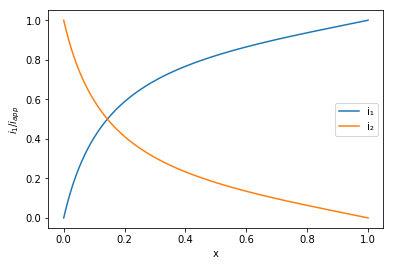

In [45]:
iapp = 0.02 #A/cm^2
#electrode surface area    
a = 23300 #cm^2/cm^3... cm^-1
#length
L = 1 # cm
#number of electrons
n = 2
#Faraday's constant
F = 96485 #C/mol
#universal gas constantl
R = 8.3145 #J/molK
#temperature
T = 273.15 + 25 #K
#electrolyte conductivity 
kappa = 0.06 #S/cm
#electrode conductivity
sigma = 300 #S/m
sigma = sigma/100 #S/cm
#transfer coefficient
alpha = 0.5
beta = (1-alpha)*n*F/R/T

#exchange current density
#i_o = 2e-7 #A/cm^2
#i_o = (0.009838027698240602 + 0.009849498195788928 + 0.009856505279562468)/3 
#i_o= (0.000017945811609164856 + 0.000018038360660111245 + 0.000017995624361842263)/3

#diffusion coefficient
Ds = 1e-6 #cm^2/s


def f(x,y):
    #unpack the vector into its 4 variables
    phi2,phi1,i1,i2=y
    
    #specify the 4 differential equations
    dphi1_dx = -i1/sigma
    dphi2_dx = -i2/kappa
    
    di1_dx = a*i_o*np.exp(beta*(phi1-phi2))
    di2_dx = -a*i_o*np.exp(beta*(phi1-phi2))
    
    df_dx = np.array([dphi1_dx,dphi2_dx,di1_dx,di2_dx])  
    
    return df_dx

x=np.linspace(0,L,101)
y_a=np.zeros((4,len(x)))

def bounds(y0,yf):

    phi10,phi20,i10,i20 = y0
    phi1f,phi2f,i1f,i2f = yf

    phi1_bc = i10 - 0
    phi2_bc = phi2f - 0
    i1_bc = i1f - iapp
    i2_bc = i20 - iapp

    y = np.array((phi1_bc,phi2_bc,i1_bc,i2_bc))
    return y

i_o = (0.009838027698240602 + 0.009849498195788928 + 0.009856505279562468)/3 
sol=solve_bvp(f,bounds,x,y_a)
plt.figure(0)


plt.plot(sol.x/L,sol.y[2]/iapp,label=u'i\u2081')
plt.plot(sol.x/L,sol.y[3]/iapp,label=u'i\u2082')

plt.legend()    
plt.xlabel('x')
plt.ylabel('j')
plt.ylabel("$i_1$/$i_{app}$")

Text(0,0.5,'j')

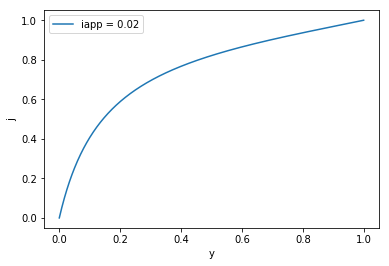

In [46]:

sol=solve_bvp(f,bounds,x,y_a)
plt.figure(0)
plt.plot(sol.x/L,sol.y[2]/iapp,label='iapp = %.2f' %(iapp))
plt.legend()    
plt.xlabel('y')
plt.ylabel('j')

Text(0,0.5,'phi2')

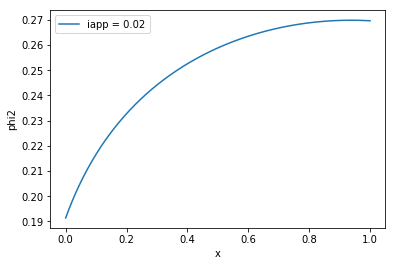

In [47]:
sol=solve_bvp(f,bounds,x,y_a)
plt.figure(0)
phi = sol.y[0]-sol.y[1]
plt.plot(sol.x/L,phi,label='iapp = %.2f' %(iapp))
plt.legend()    
plt.xlabel('x')
plt.ylabel('phi2')

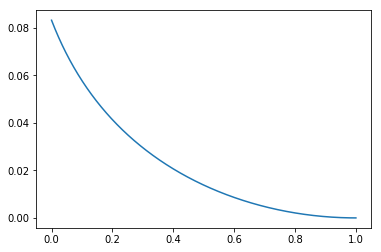

In [48]:
plt.plot(sol.x,sol.y[1])

Equation to model the change in the exchange current density due to the change in fundamental insertion reaction.
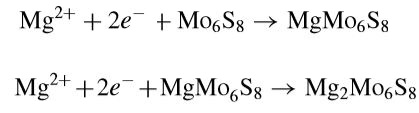


In [49]:
### both the kinetics and diffusivity in the solid differed greatly in the two reactions. 

def func_io(y):
    i_ofast = (0.009838027698240602 + 0.009849498195788928 + 0.009856505279562468)/3 
    i_oslow= (0.000017945811609164856 + 0.000018038360660111245 + 0.000017995624361842263)/3
    S_i = 50
    b = (i_ofast + i_oslow)/2
    b_ = (i_ofast - i_oslow)/2
    i_opos = b_*np.tanh(S_i*(y-0.5)) + b 
    return i_opos

In [50]:
### Temperary diffusion (cm^2/g)
Ds = 2.005445683949527e-13

Defining the differential equation for radial concentration through the solid (cathode): 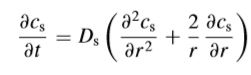

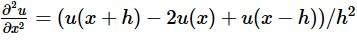

Note that it is very interesting that Kim et al. is able to model the system without boundary conditions for the concetration in the particles that does not involve the concentration of the electrolyte immediately adjacent. However, it does take into account the nominal cathode current (franction of current carried by the solid cathode material), which itself is dependent on the voltage of the electrolyte and cathode material as a function of depth into the cathode. That is to say, the interaction of the concentration of the cathode particles and the surround electrolyte is intricate, and seemingly very indirect. This implies that natrual diffusion of the working ion into the cathode particles plays very small role. Truly, this demonstrates that for any reation to occur the circuit must be closed made apperent that the voltage, and therefore the Gibb's free energy of the system, play such an important role in the likelihood of a working ion entering into the particles even if the working ion and the surface of the cathode are in direct contact with each other. Obviously, a battery system in which the working ion inserts itself when the circuit is not closed is worthless, but it is enlightening to see the complexity of the mathematical equation's interactions re-enforcing this.

In [51]:
def funCs(Cs, t):
    dCs_dt = np.zeros(r.shape)

    # boundary condition at t = 0
    dCs_dt[0] = 0 # constant at initial boundary condition
    dCs_dt[-1] = 0 # constant at final boundary condition    
    
    # now for the internal nodes
    for i in range(1, N-1):
        #dCs_dt[i] = 1e7*Ds * (Cs[i + 1] - 2*Cs[i] + Cs[i - 1]) / h**2 + 2*Ds*(Cs[i+1] + Cs[i])/r[i]
        dCs_dt[i] = 1e7*Ds * (Cs[i + 1] - 2*Cs[i] + Cs[i - 1]) / dx**2 + 2*Ds*(Cs[i+1] + Cs[i])/r[i]/dx
    return dCs_dt



Solving ODE for concentration of electrolyte

In [52]:
### initial concentration of Mg ions in the chevrel particles (cathode material) is 0
Cso = np.zeros(r.shape)

### Initial conditions at r = initial and r = final 
Cso[0]=0
Cso[-1]=1
Cs = odeint(funCs, Cso, t)
Cs = Cs.T

Text(0,0.5,'$C_s$/$C_o$')

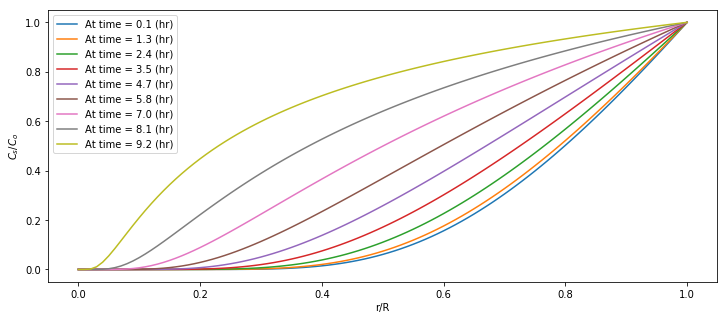

In [95]:
plt.figure(1)
plt.figure(figsize=(12,5))
for i in range(1,91,10):
    plt.plot(r/max(r),Cs[i]/max(Cs[i]),label='At time = %.1f (hr)' %(t[i]/3600))

plt.legend()
plt.xlabel('r/R')
plt.ylabel('$C_s$/$C_o$')

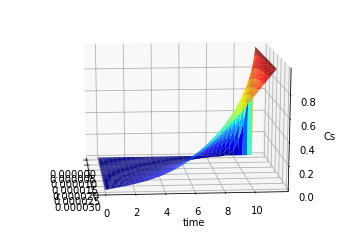

In [9]:
# Make a 3d figure
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

SX, ST = np.meshgrid(r, t)
ax.plot_surface(SX, ST/3600, Cs, cmap='jet')
ax.set_xlabel('r')
ax.set_ylabel('time')
ax.set_zlabel('Cs')
ax.view_init(elev=15, azim=-5) # adjust view so it is easy to see

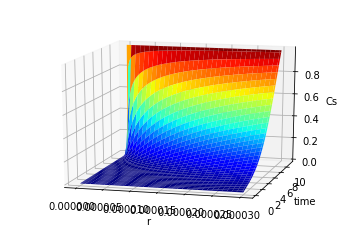

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
SX, ST = np.meshgrid(r, t)
ax.plot_surface(SX, ST/3600, Cs, cmap='jet')
ax.set_xlabel('r')
ax.set_ylabel('time')
ax.set_zlabel('Cs')
ax.view_init(elev=15, azim=-75) # adjust view so it is easy to see

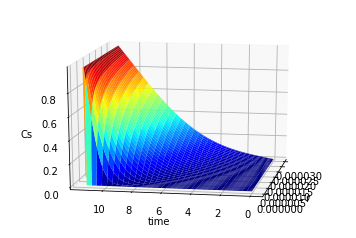

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
SX, ST = np.meshgrid(r, t)
ax.plot_surface(SX, ST/3600, Cs, cmap='jet')
ax.set_xlabel('r')
ax.set_ylabel('time')
ax.set_zlabel('Cs')
ax.view_init(elev=15, azim=-170) # adjust view so it is easy to see

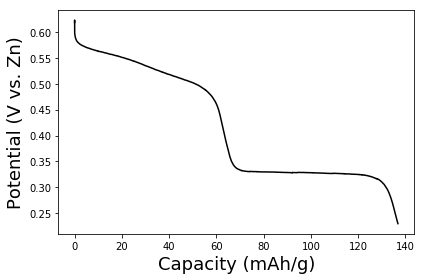

In [12]:
####getting voltage/current data
fileName = 'ch2battery2complete'

f = open('G:/My Drive/Research/APS/Al Ion/Final Data/June 2018 APS visit/%s.txt' %(fileName))
#/Users/matta/Documents/Research/Al Ion/Final Data/June 2018 APS visit/ch1battery1complete
lines = f.readlines()



a=[]
i=0
###skipping the first lines of the text file
skip = 4

tc =np.zeros(len(lines)-skip)
V = tc.copy()
I = tc.copy()
C = tc.copy()
mode = tc.copy()
mode = mode.astype(np.str)

for ln in lines[skip:len(lines)]:
    a=ln.strip().split()
    tc[i] = a[3]
    V[i] = a[8]
    mode[i] = a[9]
    if mode[i] == 'D':
        I[i]=-float(a[7])
    else:
        I[i]=a[7]     
    C[i] = a[5] ### Ahr
    i=i+1
f.close()

k=4112
plt.plot(1000*C[:k]/5.24*1000,V[:k],'k',label = 'Potential')
plt.ylabel('Potential (V vs. Zn)',fontsize=18)
plt.xlabel('Capacity (mAh/g)',fontsize=18)
plt.tight_layout()

In [13]:
De = 5e-12 # Diffusivity of electrolyte (m^2/s)
De = De * 1000 # Diffusivity of electrolyte (cm^2/s)
εe = 0.724 # Porosity of separator,  ε of seporator is ε of electrolyte???  (#)
t_plus = 0.018 # Transition number (#)
av= 9.63e5 # specific (1/m) 
av = av/100
iot = 2.003810704121193e-13 #A/m^2

Defining the differential equation for concentration through the electrolyte:
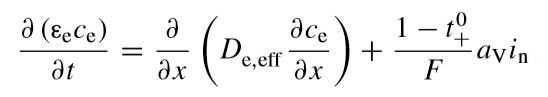

In [143]:
def funCe(Ce, t):
    dCe_dt = np.zeros(x.shape)
    xt = 0
    ### Total time of discharge
    total_time = 41035.97 # seconds
    tc = np.linspace(0,total_time,N) # time array (s)
    y = tc/total_time
    io = func_io(y)
  #  i_o = (0.009838027698240602 + 0.009849498195788928 + 0.009856505279562468)/3
    # boundary condition at t = 0
    dCe_dt[0] = 0 # constant at initial boundary condition t = 0
    dCe_dt[-1] = 1 # constant at final boundary condition t = 0   
    
    # now for the internal nodes
    for i in range(1, N-1):
        xt = h + xt
        dCe_dt[i] = ((Ce[i + 1] - 2*Ce[i] + Ce[i - 1]) / h**2)*De/εe + (1-t_plus)*av/F/εe*io[i]
        
    return dCe_dt

Solving ODE for concentration through solid

In [144]:
### initial concentration of Mg ions in the chevrel particles (cathode material) is 0
Ceo = np.zeros(x.shape)

### Initial conditions at x = initial and x = final 
Ceo[0]=1
Ceo[-1]=0
Ce = odeint(funCe, Ceo, t)
Ce = Ce.T

Text(0,0.5,'$C_e$/$C_o$')

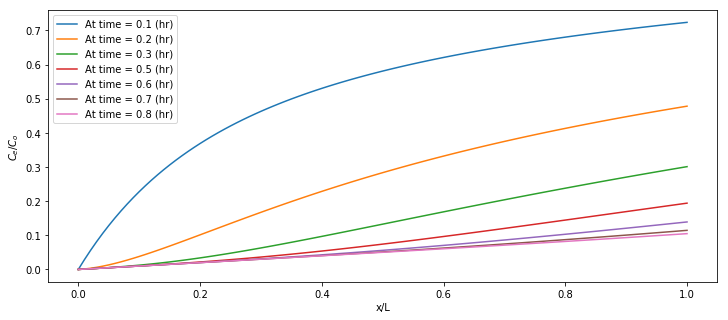

In [146]:
plt.figure(0)

plt.figure(figsize=(12,5))
for i in range(1,8):
    plt.plot(x,Ce[i],label = 'At time = %.1f (hr)' %(t[i]/3600))
    

plt.legend()    
plt.xlabel('x/L')
plt.ylabel('$C_e$/$C_o$')
#plt.ylabel("$i_1$/$i_{app}$")


The transience of the concentration gradient is very short lived. This is strong agreement with what Kim et al. demonstrated. This also strengthens the viability of of inicial calculations using steady stats values before being recalculated. 

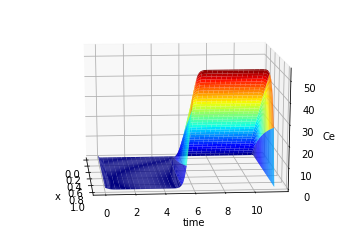

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

SX, ST = np.meshgrid(x, t)
ax.plot_surface(SX, ST/3600, Ce, cmap='jet')
ax.set_xlabel('x')
ax.set_ylabel('time')
ax.set_zlabel('Ce')
ax.view_init(elev=15, azim=-5) # adjust view so it is easy to see